In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

df = pd.read_json('FA-KSA_recording.json')

#df_filter = df.drop(columns=['ident','air_ground','adsb_version','altChange','facility_hash','facility_name','id','nav_modes','reg','squawk','updateType','hexid','orig','dest','sil','sil_type',
#                             'nac_p','nac_v','nic','temperature','temperature_quality','wind_quality','alt_gnss','aircrafttype','heading_true'])

#df_kept = df[['pitr','alt','clock','gs','heading','lat','lon','nav_qnh','nic_baro','vertRate','vertRate_geom','mach','heading_magnetic','nav_heading','nav_altitude','pressure']]

#position = ['lat','lon','alt']

#kinematic = ['gs','vertRate','heading']

#data_for_iForest = position + kinematic
#X = df[data_for_iForest]

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)


In [18]:
def seperate_transponder_data(df):
    position = ['lat','lon','alt']

    kinematic = ['gs','vertRate','heading']

    operation = ['hexid','squawk']

    data_for_iForest = position + kinematic

    X = df[data_for_iForest]
    X_drop = X.dropna()
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_drop)

    return X_scaled



In [154]:
position = ['alt'] #lat, lon

kinematic = ['gs'] # heading

operation = ['hexid','squawk']

data_for_iForest = position + kinematic

df = df.dropna(subset=data_for_iForest)

In [156]:
#iso_data_X = seperate_transponder_data(df)

In [186]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators  = 100,
    max_samples   = 100,
    contamination = 0.01,
    max_features  = 1.0,
    bootstrap     = False,
    n_jobs        = -1,
    random_state  = 12,
    verbose       = 1,
    warm_start    = False)


iso_forest.fit(df[data_for_iForest])

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.8s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.0s finished


IsolationForest(contamination=0.01, max_samples=100, n_jobs=-1, random_state=12,
                verbose=1)

In [188]:
df['anomaly_scores'] = iso_forest.decision_function(df[data_for_iForest])

In [190]:
df['anomaly'] = iso_forest.predict(df[data_for_iForest])

In [192]:
df.loc[:,['alt','gs','vertRate','anomaly_scores','anomaly']]

,alt,gs,vertRate,anomaly_scores,anomaly
0,38975.0,495.0,0.0,0.177414,1
1,36000.0,406.0,0.0,0.218167,1
2,25525.0,426.0,1600.0,0.156207,1
3,350.0,157.0,-736.0,0.004983,1
4,36000.0,407.0,0.0,0.217704,1
...,...,...,...,...,...
39087,8175.0,284.0,0.0,0.120244,1
39088,39000.0,548.0,0.0,0.171255,1
39089,33000.0,460.0,0.0,0.206162,1
39090,7925.0,289.0,-1792.0,0.109391,1


In [194]:
import seaborn as sns
def outlier_plot(data, outlier_method_name, x_var, y_var, 
                 xaxis_limits=[0,1], yaxis_limits=[0,1]):
    
    print(f'Outlier Method: {outlier_method_name}')
    
    method = f'{outlier_method_name}_anomaly'
    
    print(f"Number of anomalous values {len(data[data['anomaly']==-1])}")
    print(f"Number of non anomalous values  {len(data[data['anomaly']== 1])}")
    print(f'Total Number of Values: {len(data)}')
    
    g = sns.FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1,-1])
    g.map(sns.scatterplot, x_var, y_var)
    g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{len(data[data['anomaly']== -1])} points")
    axes[1].set_title(f"Inliers\n {len(data[data['anomaly']==  1])} points")
    return g

In [196]:
#outlier_plot(df,"Latitude vs Longitude", "lat","lon", [0,40],[20,80])

Outlier Method: Altitude vs Ground Speed
Number of anomalous values 333
Number of non anomalous values  32906
Total Number of Values: 33239


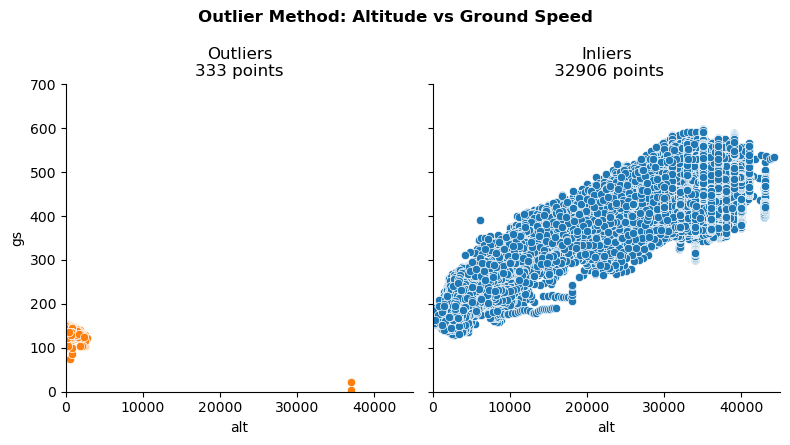

In [198]:
outlier_plot(df,"Altitude vs Ground Speed", "alt","gs", [0,45000],[0,700])